In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.tree import export_graphviz
import pydot

In [2]:
DATASET = 'SEASON'
# DATASET = 'TEAM'

if DATASET == 'TEAM':
    train = pd.read_csv('../data/train_team.csv')
    test = pd.read_csv('../data/test_team.csv')

if DATASET == 'SEASON':
    train = pd.read_csv('../data/train_season.csv')
    test = pd.read_csv('../data/test_season.csv')

In [3]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

# Random Forrest on regualr season vs playoff

In [4]:
train.head()

,period,playoffs,shot_distance,shot_made_flag,shot_zone_basic,shot_zone_range,time_remaining,last_5_games_avg,streak_before_shot,points_before_shot,...,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_away,matchup_home
0,1,0,0,0.0,0,0,660,0.0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,4,0,0,1.0,0,0,113,0.0,0,16,...,1,0,0,1,0,0,0,0,0,1
2,4,0,14,0.0,2,1,216,0.0,0,16,...,1,0,0,0,0,0,0,1,0,1
3,4,0,28,0.0,4,3,339,0.0,0,16,...,0,1,0,1,0,0,0,0,0,1
4,4,0,8,0.0,1,1,596,0.0,0,16,...,1,0,0,1,0,0,0,0,0,1


In [5]:
test.shape

(428, 31)

In [6]:
def split_x_y(df, target):
    y = df.loc[:, [target]]
    x = df.drop([target], axis=1)
    return x, y

In [7]:
target_column = "shot_made_flag"  # y_column_name

x_train, y_train = split_x_y(train, target_column)
x_test, y_test = split_x_y(test, target_column)

## READ THIS
We are using out of the bag score (oob_score) as a way to validate our model.
Instead of using validation set and introducing data leakage, with the oob_score we are estimating the validation score.
# VERIFY

In [8]:
model_rf = RandomForestClassifier(oob_score=True).fit(x_train, y_train)

/tmp/ipykernel_35092/4285322127.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf1 = RandomForestClassifier(oob_score=True).fit(x_train, y_train)


In [9]:
pred = model_rf.predict(x_train)

Performing a sanity check

In [10]:
confusion_matrix(y_train,pred)

array([[734,   0],
       [  0, 610]])

In [11]:
print('OOB accuracy=', model_rf.oob_score_)

OOB accuracy= 0.6830357142857143


In [12]:
y_pred = model_rf.predict(x_test)

In [13]:
confusion_matrix(y_test,y_pred)

array([[184,  50],
       [105,  89]])

In [14]:
results.loc['RF-basic', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.63785,0.534535,0.703633,0.619084


# Check the tree that we generated

In [58]:
x_train

,period,playoffs,shot_distance,shot_zone_basic,shot_zone_range,time_remaining,last_5_games_avg,streak_before_shot,points_before_shot,fgp_before_shot,...,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_away,matchup_home
0,1,0,0,0,0,660,0.00,0,0,0.00,...,1,0,0,1,0,0,0,0,0,1
1,4,0,0,0,0,113,0.00,0,16,0.42,...,1,0,0,1,0,0,0,0,0,1
2,4,0,14,2,1,216,0.00,0,16,0.44,...,1,0,0,0,0,0,0,1,0,1
3,4,0,28,4,3,339,0.00,0,16,0.47,...,0,1,0,1,0,0,0,0,0,1
4,4,0,8,1,1,596,0.00,0,16,0.50,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,1,0,0,0,0,386,0.43,0,0,0.00,...,1,0,0,1,0,0,0,0,0,1
1340,1,0,15,2,1,641,0.43,0,0,0.00,...,1,0,0,0,0,1,0,0,0,1
1341,4,0,30,4,3,49,0.43,0,12,0.31,...,0,1,0,1,0,0,0,0,0,1
1342,3,0,14,1,1,622,0.43,0,7,0.43,...,1,0,0,1,0,0,0,0,0,1


In [59]:
# Import tools needed for visualization

# Pull out one tree from the forest
def visualize_rf_tree(model):
    tree = model.estimators_[0]# Import tools needed for visualization
    tree = model.estimators_[0]# Export the image to a dot file
    export_graphviz(tree, out_file = 'tree.dot', feature_names = list(x_train.columns), rounded = True, precision = 1)# Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
    graph.write_png('tree.png')

In [60]:
visualize_rf_tree(model_rf)

# GridSearch

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = RandomForestClassifier()

ntrees = [10, 50, 75, 100, 200, 300, 400,  None]
max_depth = [3,5,8,10, 15,20,25, None] # depth is usually low
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=model,
                   scoring='f1', #change the scoring to accuracy?
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'class_weight':balance
                   },
                   cv=None, #is 5 fold
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

trc.fit(x_train, y_train)

/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [3, 5, 10, 25, 50, 75, None],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6],
                         'n_estimators': [10, 50, 100, 200, 300, 400, None]},
             refit=False, scoring='f1')

The best Parameters are:

In [18]:
trc.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 100}

In [19]:
model_rf_gs = RandomForestClassifier(**trc.best_params_)


In [20]:
model_rf_gs.fit(x_train, y_train)

/tmp/ipykernel_35092/2237850149.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf4_gs.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       min_samples_leaf=4, min_samples_split=4)

In [21]:
y_pred = model_rf_gs.predict(x_test)
results.loc['RF-gridsearch', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-gridsearch,0.651869,0.549849,0.71619,0.63302
RF-small,0.658879,0.503401,0.740214,0.621807
RF-basic,0.63785,0.534535,0.703633,0.619084


In [22]:
confusion_matrix(y_test, y_pred)

array([[188,  46],
       [103,  91]])

# Check feature importance

In [23]:
model_rf_gs.feature_importances_

array([0.00545457, 0.        , 0.07042349, 0.02952238, 0.0392128 ,
       0.02893406, 0.01697509, 0.00691758, 0.01886471, 0.03234756,
       0.01013143, 0.0129587 , 0.40089314, 0.12341971, 0.03805096,
       0.05267735, 0.00059772, 0.041778  , 0.0079155 , 0.        ,
       0.01259982, 0.01668249, 0.        , 0.01105683, 0.00417793,
       0.00213069, 0.00123047, 0.00151637, 0.00462417, 0.00890647])

In [24]:
# Get numerical feature importances
importances = list(model_rf_gs.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x_train.columns), importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: action_type_te       Importance: 0.16
Variable: time_remaining       Importance: 0.12
Variable: fgp_before_shot      Importance: 0.09
Variable: opponent_te          Importance: 0.09
Variable: points_before_shot   Importance: 0.08
Variable: shot_distance        Importance: 0.07
Variable: last_5_games_avg     Importance: 0.07
Variable: month                Importance: 0.05
Variable: weekday              Importance: 0.05
Variable: period               Importance: 0.04
Variable: streak_before_shot   Importance: 0.04
Variable: shot_zone_basic      Importance: 0.02
Variable: shot_zone_range      Importance: 0.02
Variable: combined_shot_type_Dunk Importance: 0.01
Variable: combined_shot_type_Jump Shot Importance: 0.01
Variable: shot_zone_area_Center(C) Importance: 0.01
Variable: shot_zone_area_Left Side Center(LC) Importance: 0.01
Variable: shot_zone_area_Left Side(L) Importance: 0.01
Variable: shot_zone_area_Right Side Center(RC) Importance: 0.01
Variable: shot_zone_area_Right Side

If we change the model, we would still get action_type_te as most important

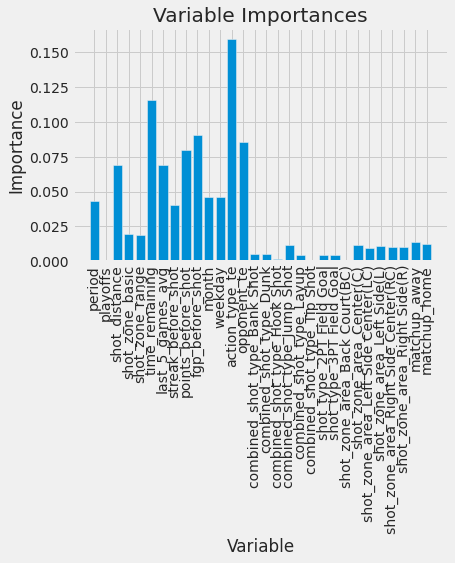

In [25]:
# Set the style
plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, list(x_train.columns), rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Run with reduced features
get only the first five top features and run the GridSearch model

In [26]:
top_features = [tuple[0] for tuple in feature_importances[:5]]

In [27]:
top_features

['action_type_te',
 'time_remaining',
 'fgp_before_shot',
 'opponent_te',
 'points_before_shot']

In [28]:
x_train_top = x_train.loc[:, top_features]
x_test_top = x_test.loc[:, top_features]

In [29]:
x_test_top

,action_type_te,time_remaining,fgp_before_shot,opponent_te,points_before_shot
0,0.811765,443,0.00,0.441176,0
1,0.291492,194,0.31,0.441176,11
2,0.937500,242,0.27,0.441176,9
3,0.600000,277,0.29,0.441176,9
4,0.291492,391,0.25,0.441176,6
...,...,...,...,...,...
423,0.357664,488,0.00,0.500000,0
424,0.291492,498,0.00,0.500000,0
425,0.291492,237,0.31,0.500000,10
426,0.790698,154,0.14,0.500000,2


In [30]:
model_rf_top5 = RandomForestClassifier(**trc.best_params_)

In [31]:
model_rf_top5.fit(x_train_top, y_train)

/tmp/ipykernel_35092/4164285385.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf5_top.fit(x_train_top, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       min_samples_leaf=4, min_samples_split=4)

In [32]:
y_pred = model_rf_top5.predict(x_test_top)

In [33]:
y_pred = model_rf_top5.predict(x_test)
results.loc['RF-gridsearch-top', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-gridsearch,0.651869,0.549849,0.71619,0.63302
RF-gridsearch-top,0.651869,0.549849,0.71619,0.63302
RF-small,0.658879,0.503401,0.740214,0.621807
RF-basic,0.63785,0.534535,0.703633,0.619084


In [69]:
x_test.shape

(428, 59)

# TEST THINGS